# Tarefa:

Utilize a base de dados de dígitos MNIST.

1. Modifique a arquitetura do gerador base (reduzindo sua capacidade) mantendo o discriminador base.

por exemplo
- removendo camadas
- reduzindo o número de kernels por camada

2. Modifique a arquitetura do discriminador base (reduzindo sua capacidade) mantendo o gerador base.

por exemplo:
- removendo camadas
- reduzindo o número de kernels por camada

3. Varie as taxas de aprendizado do gerador e do discriminador de forma independente.
0.1 -> 0.001 -> 0.00001

4. Teste um otimizador adicional (ex.: SGD ou Adam).

Mudar os dois para Adam

5. Realize a interpolação entre dois vetores latentes.


Entregáveis:
1. Notebook
2. Relatório pdf: **Reporte e comente os resultados no relatório.**


# Setup


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from IPython.display import Image
%matplotlib inline

# Dados

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2.0 - 1.0),
])

# Baixa os dados de treinamento a partir de conjuntos de dados públicos
training_data = datasets.MNIST(
    root="data",             # Diretório onde os dados serão armazenados
    train=True,              # Indica que este é o conjunto de dados de treinamento
    download=True,           # Baixa os dados automaticamente, caso ainda não estejam presentes
    transform=transform,    # Aplica a transformação ToTensor para converter as imagens em tensores
)

# Baixa os dados de teste a partir de conjuntos de dados públicos
test_data = datasets.MNIST(
    root="data",             # Diretório onde os dados serão armazenados
    train=False,             # Indica que este é o conjunto de dados de teste
    download=True,           # Baixa os dados automaticamente, caso ainda não estejam presentes
    transform=transform,     # Aplica a transformação ToTensor para converter as imagens em tensores
)

In [3]:
batch_size = 32                                                                                     # Define o tamanho do lote
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True)   # Cria o DataLoader para o conjunto de treinamento
test_dataloader = DataLoader(test_data, batch_size=batch_size)                                      # Cria o DataLoader para o conjunto de teste

# Itera sobre o DataLoader de teste para visualizar as formas dos dados
for X, y in test_dataloader:
    # Exibe a forma e o tipo do tensor de imagens
    # N = tamanho do lote, C = canais (1 para imagens em tons de cinza), H = altura, W = largura
    print(f"Forma de X [N, C, H, W]: {X.shape}, Tipo de dados em X: {X.dtype}")

    # Exibe a forma e o tipo dos rótulos (labels)
    print(f"Forma de y [N, ] : {y.shape}, Tipo de dados em y: {y.dtype}")

    break  # Encerra o loop após a primeira iteração, apenas para inspeção dos dados

Forma de X [N, C, H, W]: torch.Size([32, 1, 28, 28]), Tipo de dados em X: torch.float32
Forma de y [N, ] : torch.Size([32]), Tipo de dados em y: torch.int64


# Modelos

In [146]:
class Gerador(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 7*7*128),
            nn.Unflatten(dim=1, unflattened_size=(128, 7, 7)),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

In [147]:
class Discriminador(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(p=0.4),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(p=0.4),
            nn.Flatten(),
            nn.Linear(7*7*128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [148]:
loss_history = {"gerador": [], "discriminador": []}


In [149]:
def train_dcgan(dataloader:DataLoader, gerador:nn.Module, discriminador:nn.Module, loss_fn: nn.BCELoss, opt_gerador, opt_discriminador, device, epoch, z_dim):
    gerador.train()         # Coloca o modelo em modo de treinamento (ativa dropout, batchnorm, etc., se houver)
    discriminador.train()   # Coloca o modelo em modo de treinamento (ativa dropout, batchnorm, etc., se houver)

    size = len(dataloader.dataset)
    for batch, (real_data, _) in enumerate(dataloader):

        batch_size = real_data.shape[0]
        real_data = real_data.to(device)

        # ========================================
        # Treinamento do DISCRIMINADOR
        # ========================================

        # Gera rótulos para dados reais (1) e falsos (0)
        labels_reais = torch.ones((batch_size, 1), device=device)
        labels_falsos = torch.zeros((batch_size, 1), device=device)

        # Gera dados falsos a partir de ruído aleatório (distribuicão normal)
        z = torch.randn((batch_size, z_dim), device=device)
        dados_falsos = gerador(z)

        # Calcula a saída do discriminador para dados reais e falsos
        saida_reais = discriminador(real_data)
        saida_falsos = discriminador(dados_falsos.detach())  # detach() evita que os gradientes fluam para o gerador

        # Calcula a perda do discriminador
        perda_reais = loss_fn(saida_reais, labels_reais)
        perda_falsos = loss_fn(saida_falsos, labels_falsos)
        perda_discriminador = perda_reais + perda_falsos

        # Atualiza o discriminador
        opt_discriminador.zero_grad()
        perda_discriminador.backward()
        opt_discriminador.step()

        # ========================================
        # Treinamento do GERADOR
        # ========================================

        # Gera novos vetores latentes
        z = torch.randn((batch_size, z_dim), device=device)
        dados_falsos = gerador(z)

        # Queremos que o discriminador pense que os dados falsos são reais
        saida_falsos = discriminador(dados_falsos)
        perda_gerador = loss_fn(saida_falsos, labels_reais)  # usamos labels_reais aqui!

        # Atualiza o gerador
        opt_gerador.zero_grad()
        perda_gerador.backward()
        opt_gerador.step()
        # ========================================
        # Log de progresso
        # ========================================
        if batch % 100 == 0 or batch == len(dataloader) - 1:
            print(f"[Época {epoch:03d}] [Lote {batch:03d}/{len(dataloader)}] "
                  f"Perda D: {perda_discriminador.item():.4f} | Perda G: {perda_gerador.item():.4f}")
            # Armazena as perdas para análise posterior
            loss_history["gerador"].append(perda_gerador.item())
            loss_history["discriminador"].append(perda_discriminador.item())

    return loss_history


In [150]:
# Define a função de gerar dados falsos de um vetor latente fixo
def gerar(gerador, device, z_dim=100):
    gerador.eval()                  # Coloca o modelo em modo de avaliação (desativa dropout, batchnorm, etc.)
    # Desativa o cálculo de gradientes para economizar memória e acelerar a execução
    with torch.no_grad():
      z = torch.zeros((1, z_dim), device=device)
      dados_falsos = gerador(z).detach().cpu().numpy().reshape(28,28)
    return dados_falsos

In [151]:
z_dim = 100
# Inicializa os modelos
modelo_gerador = Gerador(z_dim)
# Imprime a arquitetura do modelo
print(modelo_gerador)
# Inicializa os modelos
modelo_discriminador = Discriminador()
# Imprime a arquitetura do modelo
print(modelo_discriminador)

# Opcional: tenta usar GPU se disponível
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#device="cpu"
modelo_gerador.to(device)
modelo_discriminador.to(device)

# Exibe qual dispositivo está sendo utilizado
print(f"Usando {device}.")

Gerador(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(128, 7, 7))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): Tanh()
  )
)
Discriminador(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.4, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.4, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_featu

# Treinamento

In [152]:
# Otimizadores
# VARIAR TODOS ESSES 
lr_gerador = 0.00001        # taxa de aprendizagem do gerador
lr_discriminador = 0.001   # learning rate do discriminador
optimizador_gerador = torch.optim.RMSprop(modelo_gerador.parameters(), lr=lr_gerador)
optimizador_discriminador = torch.optim.RMSprop(modelo_discriminador.parameters(), lr=lr_discriminador)

# Função de perda
loss_fn = nn.BCELoss()
num_epochs = 10  # Define o número total de épocas (iterações completas sobre o conjunto de dados de treinamento)
evolução_dado_falso = []
for epoca in range(1, num_epochs + 1):
    train_dcgan(
        dataloader=train_dataloader,
        gerador=modelo_gerador,
        discriminador=modelo_discriminador,
        loss_fn=loss_fn,
        opt_gerador=optimizador_gerador,
        opt_discriminador=optimizador_discriminador,
        device=device,
        epoch=epoca,
        z_dim=z_dim
    )
    if epoca % 2 == 0 or epoca == 1:
      evolução_dado_falso.append(gerar(gerador=modelo_gerador, device=device, z_dim=z_dim))
print("Fim!")  # Exibe mensagem final indicando que o treinamento terminou

[Época 001] [Lote 000/1875] Perda D: 1.4386 | Perda G: 2.9275
[Época 001] [Lote 100/1875] Perda D: 0.0000 | Perda G: 27.2772
[Época 001] [Lote 200/1875] Perda D: 0.0000 | Perda G: 39.3179
[Época 001] [Lote 300/1875] Perda D: 0.0000 | Perda G: 48.8900
[Época 001] [Lote 400/1875] Perda D: 0.0000 | Perda G: 46.9345
[Época 001] [Lote 500/1875] Perda D: 0.0000 | Perda G: 49.5454
[Época 001] [Lote 600/1875] Perda D: 0.0000 | Perda G: 78.0508
[Época 001] [Lote 700/1875] Perda D: 0.0000 | Perda G: 82.2547
[Época 001] [Lote 800/1875] Perda D: 0.0000 | Perda G: 57.0009
[Época 001] [Lote 900/1875] Perda D: 0.0000 | Perda G: 58.5352
[Época 001] [Lote 1000/1875] Perda D: 0.0000 | Perda G: 81.6909
[Época 001] [Lote 1100/1875] Perda D: 0.0000 | Perda G: 80.6211
[Época 001] [Lote 1200/1875] Perda D: 0.0000 | Perda G: 75.3602
[Época 001] [Lote 1300/1875] Perda D: 0.0000 | Perda G: 83.3394
[Época 001] [Lote 1400/1875] Perda D: 0.0000 | Perda G: 79.6515
[Época 001] [Lote 1500/1875] Perda D: 0.0572 | Perd

# Resultados

In [123]:
# Salvar modelos treinados

def save_models(modelo_gerador, loss_history, nome="models"):
    import os
    os.makedirs("models", exist_ok=True)
    torch.save(modelo_gerador.state_dict(), f"models/{nome}.pth")

    # Salvar loss_history
    import json
    with open(f"models/{nome}_loss.json", "w") as f:
        json.dump(loss_history, f)

In [124]:
# Plota a evolução das perdas ao longo do treinamento
def plot_loss_history(loss_history, nome="loss_history"):
    plt.figure(figsize=(12, 5))
    plt.plot(loss_history["gerador"], label="Perda Gerador")
    plt.plot(loss_history["discriminador"], label="Perda Discriminador")
    plt.xlabel("Batches (x100)")
    plt.ylabel("Perda")
    #plt.ylim(1e-5, 105)
    plt.legend()
    plt.title("Evolução das Perdas durante o Treinamento")
    plt.savefig(f"{nome}_loss.png")
    plt.show()

In [125]:
# Define a função de gerar dados falsos de um vetores latentes aleatorios
def gerar_aleatorio(gerador, device, z_dim=z_dim, n_images=20):
    gerador.eval()                  # Coloca o modelo em modo de avaliação (desativa dropout, batchnorm, etc.)
    z = torch.randn((n_images, z_dim), device=device)
    # Desativa o cálculo de gradientes para economizar memória e acelerar a execução
    with torch.no_grad():
      dados_falsos = modelo_gerador(z).detach().cpu().numpy()
    return dados_falsos

# Função para plotar várias imagens em um grid
def plot_multiple_images(imagens, n_cols=7, nome="generated"):
    n_cols = n_cols
    n_rows = (len(imagens) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, img in enumerate(imagens):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(img.reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.savefig(f"{nome}_random.png")
    plt.show()

## Intepolação

In [126]:
# Função que interpola entre dois vetores latentes e gera imagens correspondentes
def interpolar_espaco_latente(gerador, z_dim=100, steps=10, device='cpu'):

    # Gera dois vetores latentes aleatórios
    z1 = torch.randn((1, z_dim), device=device)
    z2 = torch.randn((1, z_dim), device=device)

    gerador.eval()  # Coloca o gerador em modo de avaliação

    alpha_valores = torch.linspace(0, 1, steps).to(device)  # Valores de interpolação entre 0 e 1
    imagens_interpoladas = []

    for alpha in alpha_valores:
        # Interpola linearmente entre z1 e z2: z_interp = (1 - alpha) * z1 + alpha * z2 , alpha em [0, 1]
        z_interp = (1 - alpha) * z1 + alpha * z2

        with torch.no_grad():  # Evita calcular gradientes (modo de inferência)
            imagem_gerada = gerador(z_interp.to(device)).cpu()

        # Remove dimensões extras e converte para numpy
        imagens_interpoladas.append(imagem_gerada.squeeze().numpy())

    return imagens_interpoladas

# Função para plotar uma lista de imagens em uma única linha
def plotar_imagens(imagens, nome= "imagens"):
    fig, eixos = plt.subplots(1, len(imagens), figsize=(len(imagens), 1.5))
    for ax, img in zip(eixos, imagens):
        ax.imshow(img.reshape(28, 28), cmap='gray')  # Mostra a imagem em escala de cinza
        ax.axis('off')                               # Remove os eixos para visualização limpa
    plt.tight_layout()
    plt.savefig(f"{nome}_interp.png")
    plt.show()
    

# Gerar resultados

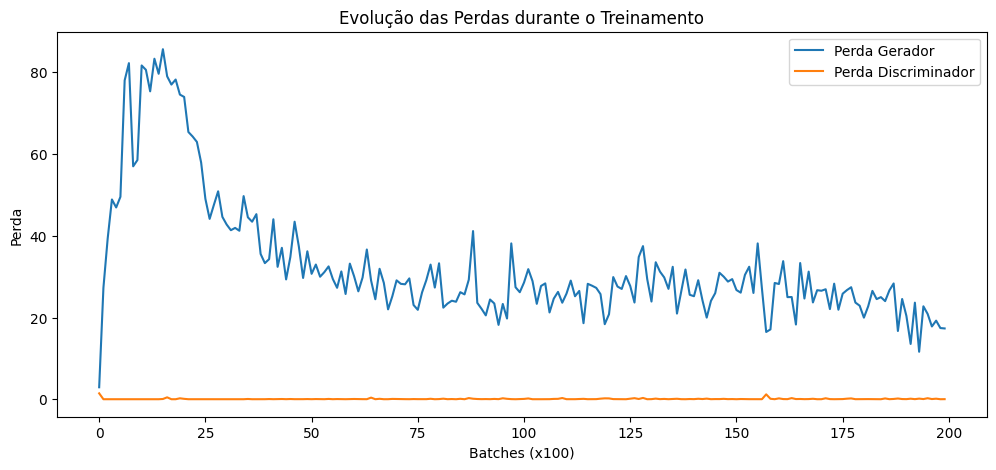

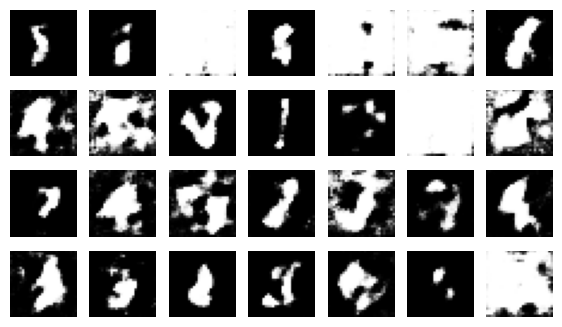

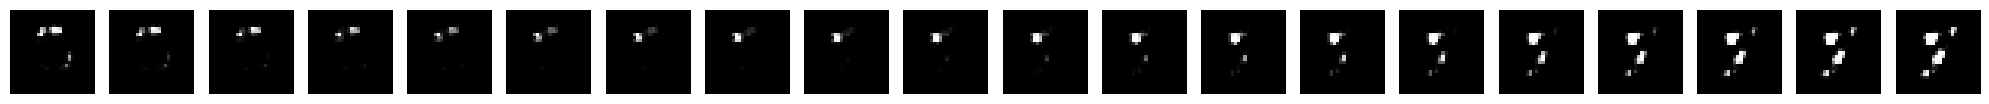

In [153]:
NOME = "low_gen"

save_models(modelo_gerador, loss_history, nome=NOME)
plot_loss_history(loss_history, nome=NOME)
# Gera um lote com imagens falsas
imagens = gerar_aleatorio(modelo_gerador, device, z_dim=z_dim, n_images=28)

# Chama a função para plotar as imagens
plot_multiple_images(imagens, n_cols=7, nome=NOME)

# Gera imagens interpoladas entre z1 e z2
imagens = interpolar_espaco_latente(modelo_gerador, z_dim=z_dim, steps=20, device=device)

# Plota as imagens lado a lado
plotar_imagens(imagens, nome=NOME)